# 3. カテゴリ分類

### 準備

In [1]:
import sys
import numpy as np
import pickle
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import keras
from keras.models import Model
from keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Input, Activation, Add, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

random_state = 2

v_size = 300  # word2vec の次元
word_num = 300  # そろえる単語数
epochs = 16
batch_size = 32

# iLect環境用  ./が効かないようなので
f_dir = '/root/userspace/dl4us_final_report/'

Using TensorFlow backend.


In [2]:
# カテゴリ辞書の関数

def category_dic():
    ''' カテゴリの 文字 <-> 番号 変換用辞書 '''

    dic = {'SCL': 0,  # school 学校
           'RLW': 1,  # railway 鉄道（交通関連）
           'FML': 2,  # family 旧家
           'BLD': 3,  # building 建造物
           'SNT': 4,  # Shinto 神道
           'PNM': 5,  # person name 人名
           'GNM': 6,  # geographical name 地名
           'CLT': 7,  # culture 伝統文化（現代文化も含む）
           'ROD': 8,  # road 道路
           'BDS': 9,  # Buddhism 仏教
           'LTT': 10,  # literature 文学
           'TTL': 11,  # title 役職・称号
           'HST': 12,  # history 歴史
           'SAT': 13,  # shrines and temples 神社仏閣
           'EPR': 14}  # emperor 天皇

    return dic


def cat2id(cha):
    ''' カテゴリの文字を番号に '''

    dic = category_dic()
    
    return dic[cha]


def id2cat(id):
    ''' カテゴリの番号を文字に '''
    
    dic_rev = {i: c for c, i in category_dic().items()}

    return dic_rev[id]

## 3.1 データ読み込み、整形

In [3]:
docs = pickle.load(open(f_dir + 'pickles/shf_tkn_docs.pickle', 'rb'))
labels = pickle.load(open(f_dir + 'pickles/shf_labels.pickle', 'rb'))

w2v_model = Word2Vec.load(f_dir + 'models/w2v_' + str(v_size) + '.model')

# 各文書、単語数をword_numにそろえ、ベクトル化
x2 = []
for n, doc in enumerate(docs):
    a_tokens = []
    for line in doc:
        a_tokens += line
    if len(a_tokens) >= word_num:
        tokens = [w2v_model[t] for t in a_tokens[:word_num]]

    # 短ければゼロ埋め
    else:
        tokens = [w2v_model[t] for t in a_tokens] \
               + [[0.0] * v_size for i in range(word_num - len(a_tokens))]

    x2.append(tokens)
    # x2はnumpy arrayにするとMemoryErrorになるのでlistのまま。generatorでnumpy arrayにする

# 教師ラベルは('カテゴリ', '言語')のうちの'カテゴリ'
y2 = [cat2id(label[0]) for label in labels]
y2 = np.eye(len(category_dic()))[y2]  # 1-hot
                
# x2はlist, y2はnumpy配列
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.15, random_state=random_state)
x2_train, x2_valid, y2_train, y2_valid = train_test_split(x2_train, y2_train, test_size=0.1, random_state=random_state)

## 3.2 モデル構築

In [4]:
def batch_gen(x2_list, y2_npy, batch_size=32):
    '''
    ミニバッチジェネレータ
    【入力】x2_list:文書はlistなのでnumpy array化。
            y2_npy :カテゴリラベル。そのまま。
    '''
    if len(x2_list) != len(y2_npy):
        print('x2 length ne y2 length', file=sys.stderr)
        sys.exit()

    n_batches = -(-len(x2_list) // batch_size)  # 1epochのbatch数。切り上げ。
    
    while True:
        for i in range(n_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            
            x2_mb = np.array(x2_list[start: end])
            x2_mb = x2_mb.reshape(x2_mb.shape[0], x2_mb.shape[1], x2_mb.shape[2], 1)

            y2_mb = y2_npy[start: end]
                    
            yield x2_mb, y2_mb

In [5]:
# 学習率
lr_start = 0.002
lr_end = 0.00005
learning_rates = np.linspace(lr_start, lr_end, epochs)
lrs_callback = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

# Skip Connection の関数
def resblock(x, filters=16, kernel_size=(5,5)):
    x_ = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x_ = BatchNormalization()(x_)
    x_ = Activation('relu')(x_)
    x_ = Dropout(0.3)(x_)
    x_ = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x_)
    x = Add()([x_, x])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# モデル作成
inputs = Input(shape=(300, 300, 1))
x = Conv2D(4, kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer='he_normal')(inputs)  # 300x300x4
x = resblock(x, filters=4)
x = resblock(x, filters=4)
x = AveragePooling2D(pool_size=(5, 5))(x)  # 60x60x4
x = Conv2D(8, kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer='he_normal')(x)  # 60x60x8
x = resblock(x, filters=8)
x = resblock(x, filters=8)
x = AveragePooling2D(pool_size=(3, 3))(x)  # 20x20x8
x = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer='he_normal')(x)  # 20x20x16
x = resblock(x, filters=16)
x = resblock(x, filters=16)
x = AveragePooling2D(pool_size=(2, 2))(x)  # 10x10x16
x = Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer='he_normal')(x)  # 10x10x32
x = resblock(x, filters=32)
x = resblock(x, filters=32)
x = AveragePooling2D(pool_size=(2, 2))(x)  # 5x5x32
x = Flatten()(x)  # 800
x = Dense(360, activation='relu', kernel_initializer='he_normal')(x)  # 360
x = Dense(120, activation='relu', kernel_initializer='he_normal')(x)  # 120
x = Dense(54, activation='relu', kernel_initializer='he_normal')(x)  # 54
y = Dense(15, activation='softmax')(x)  # 15

model = Model(inputs=inputs, outputs=y)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

## 3.3 学習

In [6]:
n_batches_train = -(-len(x2_train) // batch_size)
n_batches_valid = -(-len(x2_valid) // batch_size)

fit2 = model.fit_generator(batch_gen(x2_train, y2_train, batch_size), epochs=epochs, steps_per_epoch=n_batches_train,
                    validation_data=batch_gen(x2_valid, y2_valid, batch_size), validation_steps=n_batches_valid, 
                    callbacks=[lrs_callback])

model.save(f_dir + 'models/clas_cat_cnn.h5')

Epoch 1/16
675/675 [==============================] - 549s 814ms/step - loss: 1.9183 - acc: 0.4233 - val_loss: 3.3631 - val_acc: 0.4123
Epoch 2/16
675/675 [==============================] - 545s 807ms/step - loss: 1.4344 - acc: 0.5379 - val_loss: 1.4594 - val_acc: 0.5406
Epoch 3/16
675/675 [==============================] - 545s 808ms/step - loss: 1.2284 - acc: 0.6009 - val_loss: 1.9965 - val_acc: 0.4731
Epoch 4/16
675/675 [==============================] - 545s 807ms/step - loss: 1.1066 - acc: 0.6375 - val_loss: 2.0096 - val_acc: 0.5565
Epoch 5/16
675/675 [==============================] - 544s 806ms/step - loss: 1.0098 - acc: 0.6655 - val_loss: 1.6498 - val_acc: 0.5569
Epoch 6/16
675/675 [==============================] - 545s 807ms/step - loss: 0.9268 - acc: 0.6908 - val_loss: 1.8656 - val_acc: 0.5202
Epoch 7/16
675/675 [==============================] - 544s 807ms/step - loss: 0.8584 - acc: 0.7118 - val_loss: 1.3420 - val_acc: 0.6219
Epoch 8/16
675/675 [============================

## 3.4 学習経過の記録

In [7]:
import pandas as pd

list_ = [fit2.history['loss'], fit2.history['val_loss'], fit2.history['acc'], fit2.history['val_acc']]
df = pd.DataFrame(list_, index=['loss', 'val_loss', 'acc', 'val_acc'], columns=range(1, epochs + 1))
df.to_pickle(f_dir + 'histories/fit2_history_df.pickle')
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
loss,1.918541,1.434459,1.228401,1.106654,1.009776,0.926821,0.858439,0.809714,0.781054,0.742644,0.714391,0.686408,0.658403,0.635061,0.607338,0.594052
val_loss,3.363144,1.459421,1.996499,2.009635,1.649762,1.865578,1.342039,1.111675,0.996892,0.970303,0.958458,0.896558,0.885783,0.833596,0.796225,0.688673
acc,0.423225,0.537867,0.600862,0.637501,0.665524,0.690815,0.711844,0.726759,0.738710,0.747603,0.757423,0.766872,0.775441,0.782574,0.788225,0.794525
val_acc,0.412255,0.540642,0.473114,0.556482,0.556899,0.520217,0.621926,0.650271,0.681951,0.691955,0.697791,0.719883,0.722801,0.732805,0.752397,0.771571


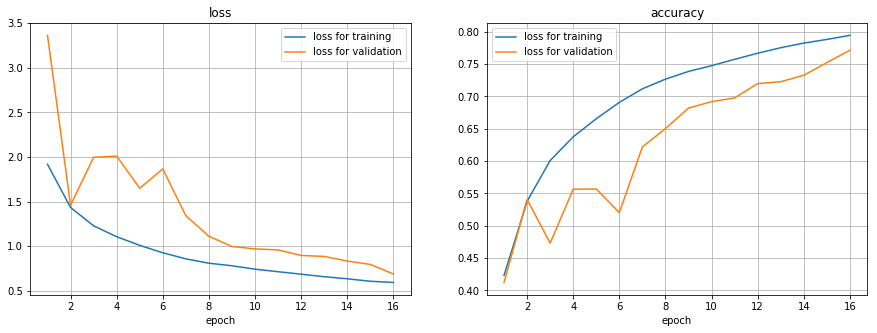

In [8]:
%matplotlib inline

# loss, accu plot
fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(121)
ax1.set_title('loss')
ax1 = df.loc['loss'].plot(label='loss for training')
ax1 = df.loc['val_loss'].plot(label='loss for validation')
ax1.set_xlabel('epoch')
ax1.set_xticks(range(2, epochs+1, 2))
ax1.grid()
ax1.legend()
ax2 = fig1.add_subplot(122)
ax2.set_title('accuracy')
ax2 = df.loc['acc'].plot(label='loss for training')
ax2 = df.loc['val_acc'].plot(label='loss for validation')
ax2.set_xlabel('epoch')
ax2.set_xticks(range(2, epochs+1, 2))
ax2.grid()
ax2.legend()

fig1.savefig(f_dir + 'figures/fit2_plot.png')

## 3.4 予測

In [9]:
n_batches_test = -(-len(x2_test) // batch_size)

gen = batch_gen(x2_test, y2_test)
y2_predict_list = []
for n in range(n_batches_test):
    x2_test_mb, y2_test_mb = gen.__next__()
    y2_predict_mb = model.predict(x2_test_mb)
    
    y2_predict_mb = np.argmax(y2_predict_mb, axis=1)  # 確率から数値に
    y2_predict_list += y2_predict_mb.tolist()  # numpy配列重いのでリストに

y2_test_n = np.argmax(y2_test, axis=1)  # 1-hotから数値に
y2_test_list = y2_test_n.tolist()

In [10]:
print(len(y2_test_list))
print(len(y2_predict_list))
print(y2_test_list[:5])
print(y2_predict_list[:5])

print('accuracy:', accuracy_score(y2_test_list, y2_predict_list))
print('f1_score:', f1_score(y2_test_list, y2_predict_list, average='macro'))

4234
4234
[9, 14, 4, 7, 5]
[9, 14, 4, 7, 9]
accuracy: 0.767123287671
f1_score: 0.637306409839
